# CS337 Project 9

In [7]:
%load_ext autoreload
import time
import numpy as np
from matplotlib import pyplot as plt

## Basic Simulation

This is the simplest model of a disk, based on the assumption that seek distance = seek time. This is obviously unrealistic, as it requires the reading head to always move at the same speed (no speeding up or slowing down).

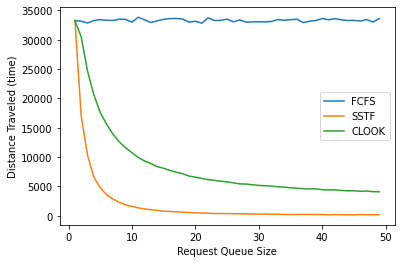

In [52]:
# import request generator and basic disk scheduling algorithms
from basic import basic_genreq, basic_fcfs, basic_sstf, basic_clook

seed = time.time_ns()

queue_sizes = np.arange(1, 50)

results = []

for i in range(queue_sizes.size):
 
    temp = np.zeros(3)

    for j in range(10):

        seed = time.time_ns()

        temp[0] += basic_fcfs(basic_genreq(100, 1000, seed))

        temp[1] += basic_sstf(basic_genreq(100, 1000, seed), queue_sizes[i])

        temp[2] += basic_clook(basic_genreq(100, 1000, seed), queue_sizes[i])

    results.append(temp/10)

results = np.asarray(results)

plt.plot(queue_sizes, results[:,0], label = 'FCFS')
plt.plot(queue_sizes, results[:,1], label = 'SSTF')
plt.plot(queue_sizes, results[:,2], label = 'CLOOK')

plt.xlabel('Request Queue Size')
plt.ylabel('Distance Traveled (time)')

plt.legend()

plt.show()

## Better Disk Simulation

By making some physical assumptions about the disk we can do a much better. Here I am trying to approximate [this 3.5" 1TB hard drive](https://www.seagate.com/www-content/product-content/barracuda-fam/barracuda-new/en-us/docs/100804187a.pdf). Two helpful sources were [this](http://www2.cs.uh.edu/~paris/7360/PAPERS03/IEEEComputer.DiskModel.pdf) and [this](https://blog.stuffedcow.net/2019/09/hard-disk-geometry-microbenchmarking/).

**Assumptions:**
- Writeable area is a ring with ID of `35 mm` and OD of `91 mm`
- Arm acceleration of `30-40 g`  (`300000-400000 mm/s^2`)
- `352,000` tracks per inch * `2.204 in` (or `56 mm = 91 mm - 35 mm`) = `775808` tracks/surface
- 1TB is composed of `1953525168` 512-byte sectors or `244190646` 4096-byte sectors
- 1 platter with 2 surfaces each having `122095323` 4096-byte sectors

In [102]:
from numpy.random import default_rng


def arm_travel_ms(d_mm):
    '''
    to account for speedup + slowdown, find time to accelerate to halfway point and double it
    '''
    a = 400000          # acceleration in mm/s^2
    t = (d_mm/a)**0.5   # find time to accelerate to halfway point
    t *= 2              # double it
    t *= 1000           # convert to ms
    return t

def seek_time_ms(current_track, target_track, RPM, rand, overhead_ms = 1):
    '''
    combine arm travel with overhead and random rotational delay
    '''
    mm_per_track = (352000/25.4)**(-1)

    dist_mm = np.abs(current_track-target_track)*mm_per_track

    time = arm_travel_ms(dist_mm) + overhead_ms + 1000*60*rand.random()/RPM

    return time




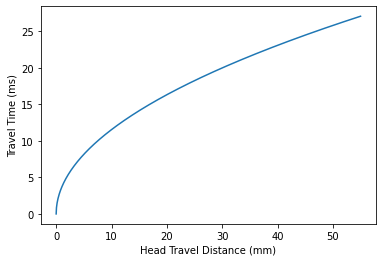

In [55]:
seek_dist_mm = np.linspace(0, 55, 1000)
plt.plot(seek_dist_mm, travel_time_ms(seek_dist_mm))
plt.xlabel('Head Travel Distance (mm)')
plt.ylabel('Travel Time (ms)')
plt.show()


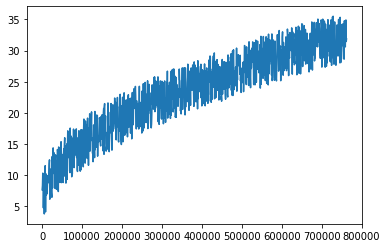

In [56]:
from numpy.random import default_rng
rand= default_rng()

track_dists = np.linspace(1, 762205, 1000)

times7200=[]
#times5400=[]
for i in range(track_dists.size):
    times7200.append(seek_time_ms(0, track_dists[i], 7200, rand))
    #times5400.append(seek_time_ms(0, track_dists[i], 5400, rand))

plt.plot(track_dists, np.asarray(times7200))
#plt.plot(track_dists, np.asarray(times5400))

plt.show()

17.678075586261702


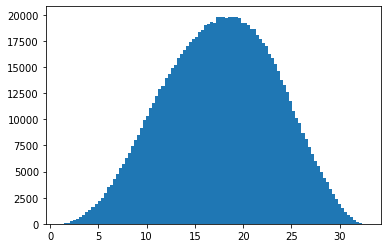

In [103]:
from numpy.random import default_rng
rand= default_rng()

times = []
for i in range(1000000):

    locs = rand.random(2)*762205

    times.append(seek_time_ms(locs[0], locs[1], 7200, rand))

fig, axes = plt.subplots(1,1)

axes.hist(times, bins=100)

print(np.mean(np.asarray(times)))

plt.show()


Using disk zoning

- 122095323 4096 byte sectors
- 16 zones each with 48488 tracks

In [100]:
zone_bounds = np.linspace(35, 91, 17)

print(zone_bounds)

areas =[]
for i in range(16):
    areas.append(np.pi*zone_bounds[i+1]**2 - np.pi*zone_bounds[i]**2)

total = np.pi*zone_bounds[-1]**2 - np.pi*zone_bounds[0]**2

percentages = np.flip(np.asarray(areas)/total)

cummulative_percent = np.cumsum(percentages)

print(cummulative_percent)

sectors = percentages*122095323

sectors_per_track = np.asarray(sectors/48488, dtype=int)

print(sectors_per_track)

sectors_per_zone = sectors_per_track*48488

print(np.sum(sectors_per_zone))

def gen_track(rand, percentages):

    rand_val = rand.random()

    for zone in range(16):
        
        if rand_val < percentages[zone]:

            break

    return zone*48488 + int(rand.random()*48488)


[35.  38.5 42.  45.5 49.  52.5 56.  59.5 63.  66.5 70.  73.5 77.  80.5
 84.  87.5 91. ]
[0.08854167 0.17361111 0.25520833 0.33333333 0.40798611 0.47916667
 0.546875   0.61111111 0.671875   0.72916667 0.78298611 0.83333333
 0.88020833 0.92361111 0.96354167 1.        ]
[222 214 205 196 187 179 170 161 153 144 135 126 118 109 100  91]
121704880


17.50598044462194


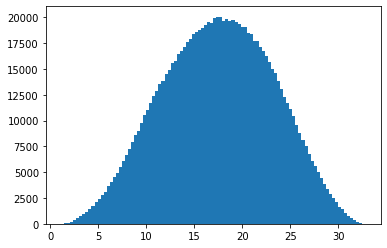

In [104]:
rand= default_rng()

times = []
for i in range(1000000):

    loc1 = gen_track(rand, cummulative_percent)
    loc2 = gen_track(rand, cummulative_percent)

    times.append(seek_time_ms(loc1, loc2, 7200, rand))

fig, axes = plt.subplots(1,1)

axes.hist(times, bins=100)

print(np.mean(np.asarray(times)))

plt.show()